First, load file metadata and dependencies. Note that rows in the metadata are already aligned to be from the same observation.

In [1]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
from settings import settings, paths
import os
import muffin
import scanpy as sc

metadata_chip = pd.read_csv(paths.immuneChipPath + "chip_meta.tsv", sep="\t", index_col="File accession")
metadata_input = pd.read_csv(paths.immuneChipPath + "input_meta.tsv", sep="\t", index_col="File accession")
metadata_peaks = pd.read_csv(paths.immuneChipPath + "peak_meta.tsv", sep="\t", index_col="File accession")
# List of paths to all files
bam_files = [paths.immuneChipPath + "chip/" + f + ".bam" for f in metadata_chip.index]
input_files = [paths.immuneChipPath + "input/" + f + ".bam" for f in metadata_input.index]
peak_files = [paths.immuneChipPath + "peak/" + f + ".bigBed" for f in metadata_peaks.index]

Now, we load the bed files for each experiment. Here they were in bigBed format so that takes a bit more code.

In [2]:
import pyBigWig
def read_bigBed_encode(path):
    bb = pyBigWig.open(path)
    chroms = bb.chroms()
    entries_list = []
    for chrom, length in chroms.items():
        entries = bb.entries(chrom, 0, length)
        for entry in entries:
            entries_list.append({
                'chrom': chrom,
                'start': int(entry[0]),
                'end': int(entry[1]),
                'name': entry[2],
            })
    df = pd.DataFrame(entries_list)
    df[["name", "Score", "Strand", "FC", "Pval", "FDR", "Summit"]] = df["name"].str.split("\t", expand=True)
    df[["FC", "Pval", "FDR"]] = df[["FC", "Pval", "FDR"]].astype("float")
    df["Summit"] = df["Summit"].astype(int)
    return df
beds = [read_bigBed_encode(f) for f in peak_files]
# Not necessary
concat_bed = pd.concat(beds)
concat_bed.to_csv("h3k4me3_results/all_beds.bed",sep="\t",header=None,index=None)

Next, we will identify consensus peaks which merges similar peaks across experiments.

In [3]:
chromSizes = pd.read_csv(paths.chromsizes, sep="\t", header=None, index_col=0).iloc[:,0].to_dict()
consensus_peaks = muffin.merge_peaks(beds, chromSizes)
consensus_peaks.to_csv("h3k4me3_results/consensus_peaks.bed",sep="\t",header=None,index=None)
# Not needed anymore
del beds

Now that we have our genomic regions of interest, we can sample the sequencing signal in BAM files and generate the count matrix. Note that you can provide custom parameters for featureCounts here. Alternatively, instead of providing a dataframe for the query regions, you can provide a path to a bed or SAF file through the genomic_regions_path argument.

In [4]:
featureCountParams = {"nthreads":16, "allowMultiOverlap":True, "minOverlap":1,
                      "countMultiMappingReads":False}
dataset = muffin.load.dataset_from_bam(bam_files, genomic_regions=consensus_peaks,
                                       input_bam_paths=input_files, 
                                       featureCounts_params=featureCountParams,chromsizes=chromSizes)

Directory tmp_muffin/ already exists !


/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/load.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedFile.loc[:, "GeneID"] = col_names



        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.8.2

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 52 BAM files                                     ||
||                                                                            ||
||                           ENCFF499NSJ.bam                                  ||
||                           ENCFF006DTI.bam                                  ||
||                           ENCFF569BNQ.bam         

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/load.py:198: UserWarning: Multiple files share the same input (this can be intended)
  warnings.warn("Multiple files share the same input (this can be intended)")


The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms.

In [5]:
print(dataset)

AnnData object with n_obs × n_vars = 52 × 163624
    var: 'Chromosome', 'Start', 'End', 'Strand'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    layers: 'input'


You can set plot settings for muffin :

In [6]:
muffin.params["autosave_plots"] = "h3k4me3_results/"
muffin.params["figure_dpi"] = 300
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=300, dpi_save=300)
sc.settings.autosave = True
sc.settings.figdir = "h3k4me3_results/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

Here, we can re-name our features (columns of the count matrix) to the nearest gene's name for convenience in downstream analyses. The dataset variable annotation has been automatically annotated with genomic locations in the previous step. Note that the gsea_obj object also provides functions for gene set enrichment of nearby genes.

In [7]:
gsea_obj = muffin.grea.pyGREAT(paths.GOfile, paths.gencode, paths.chromsizes)
dataset.var_names = gsea_obj.label_by_nearest_gene(dataset.var[["Chromosome","Start","End"]]).astype(str)

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

In [8]:
design = np.ones((dataset.X.shape[0],1))
muffin.load.set_design_matrix(dataset, design)

Now, we are count to normalize the input counts using our centering and scaling approach. Alternatively, you can use the rescale_input_quantile function. We are also going to remove features with very low signal (note that this step is mandatory to remove fully zero counts, which will cause numerical issues later on when fitting NB models).

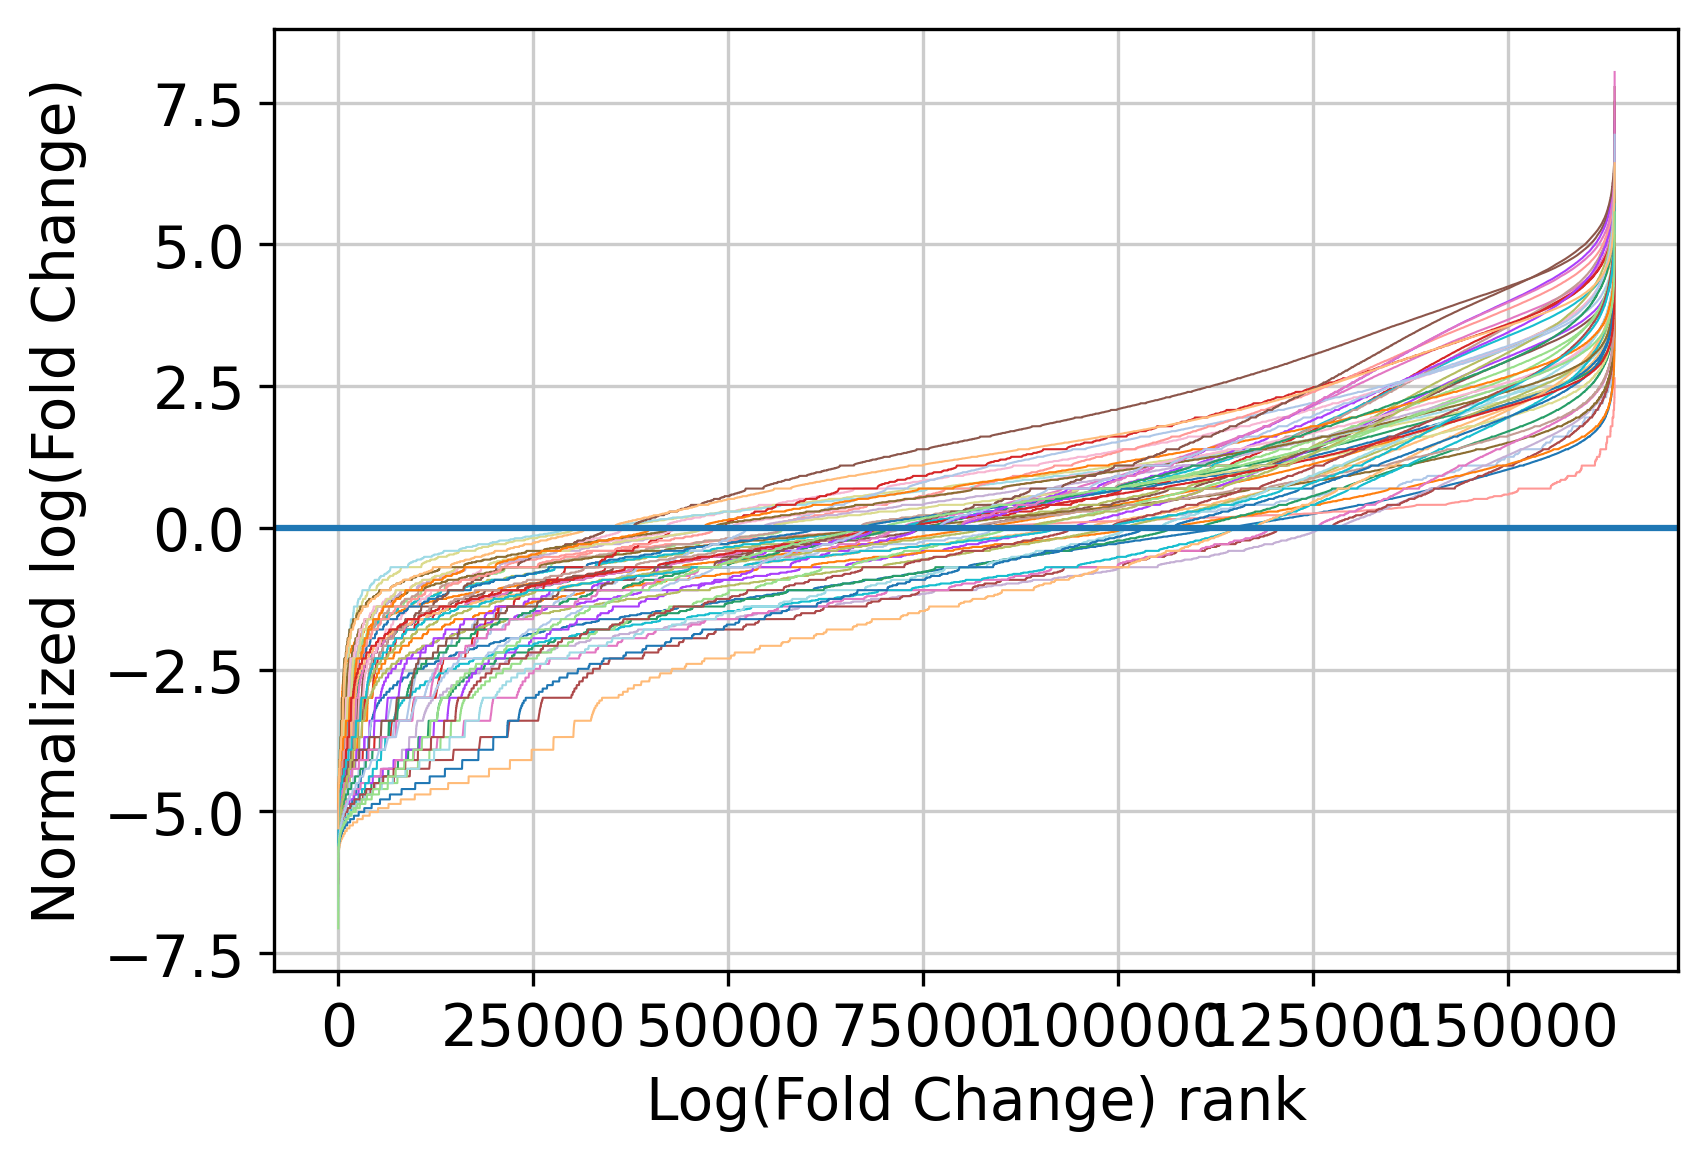

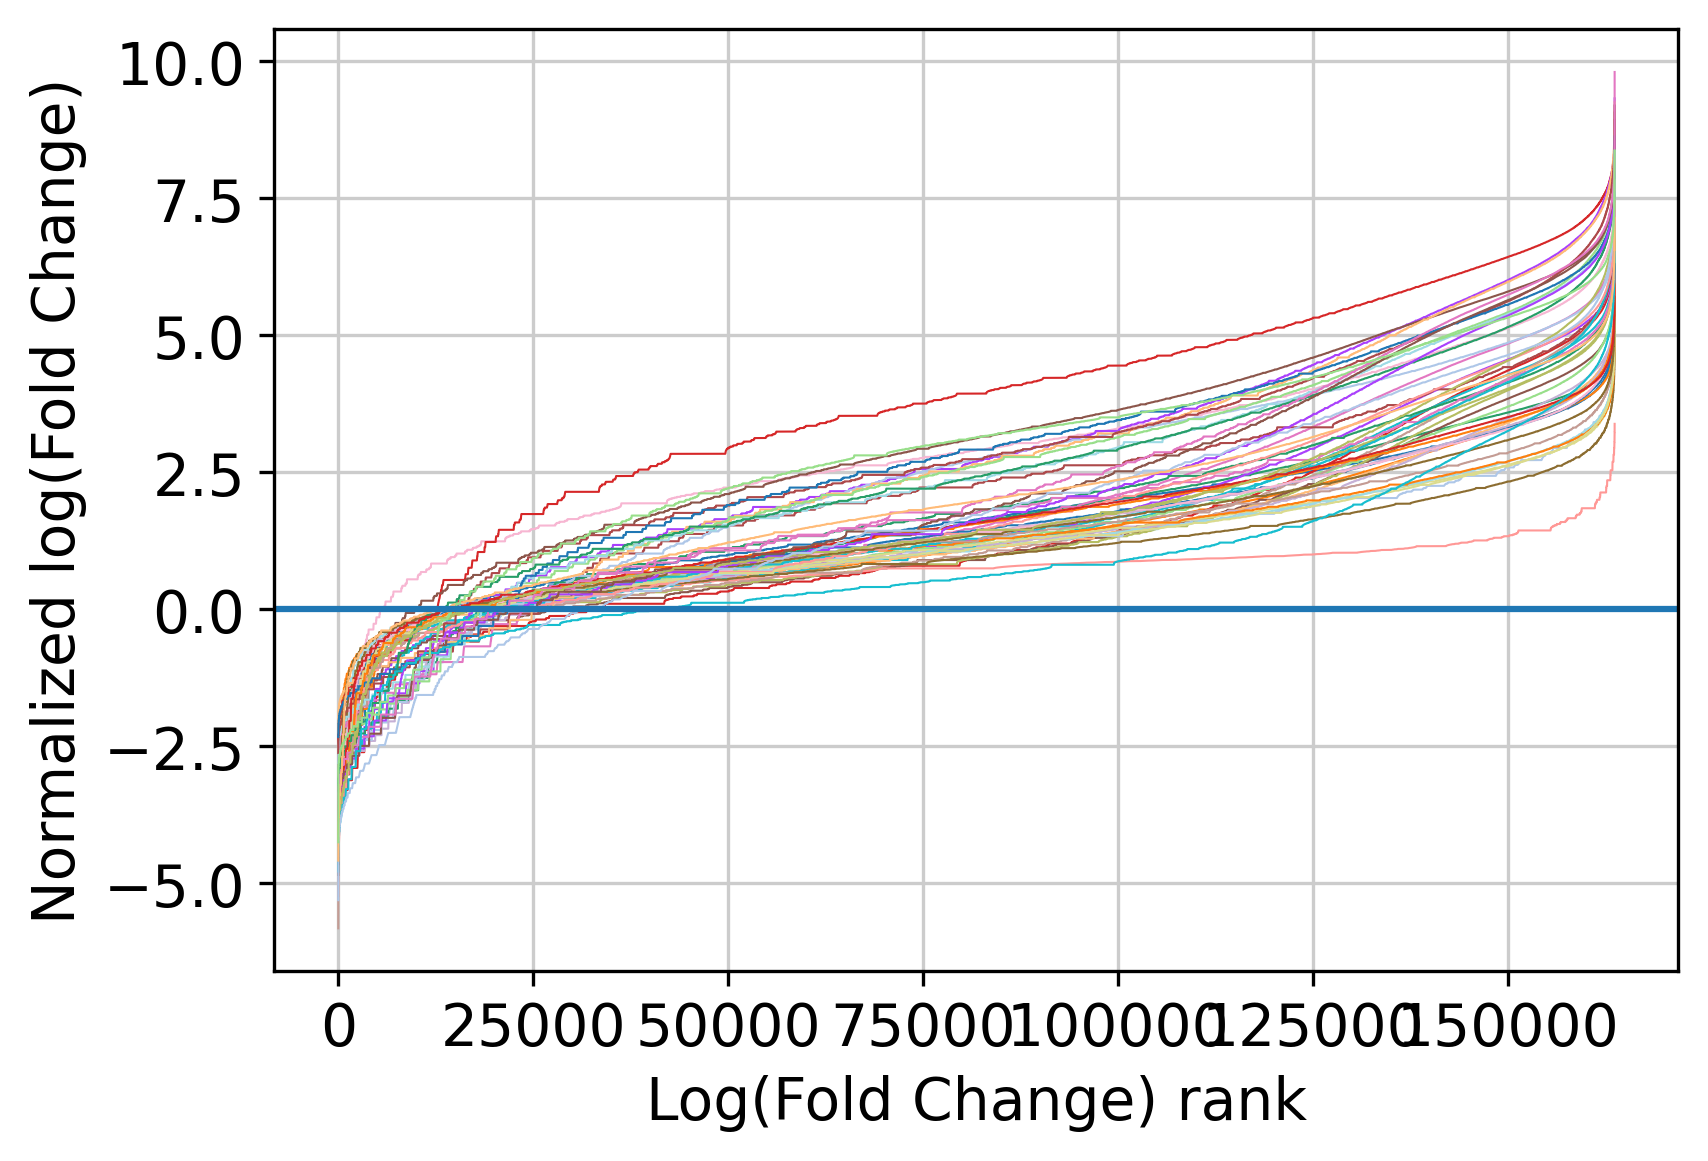

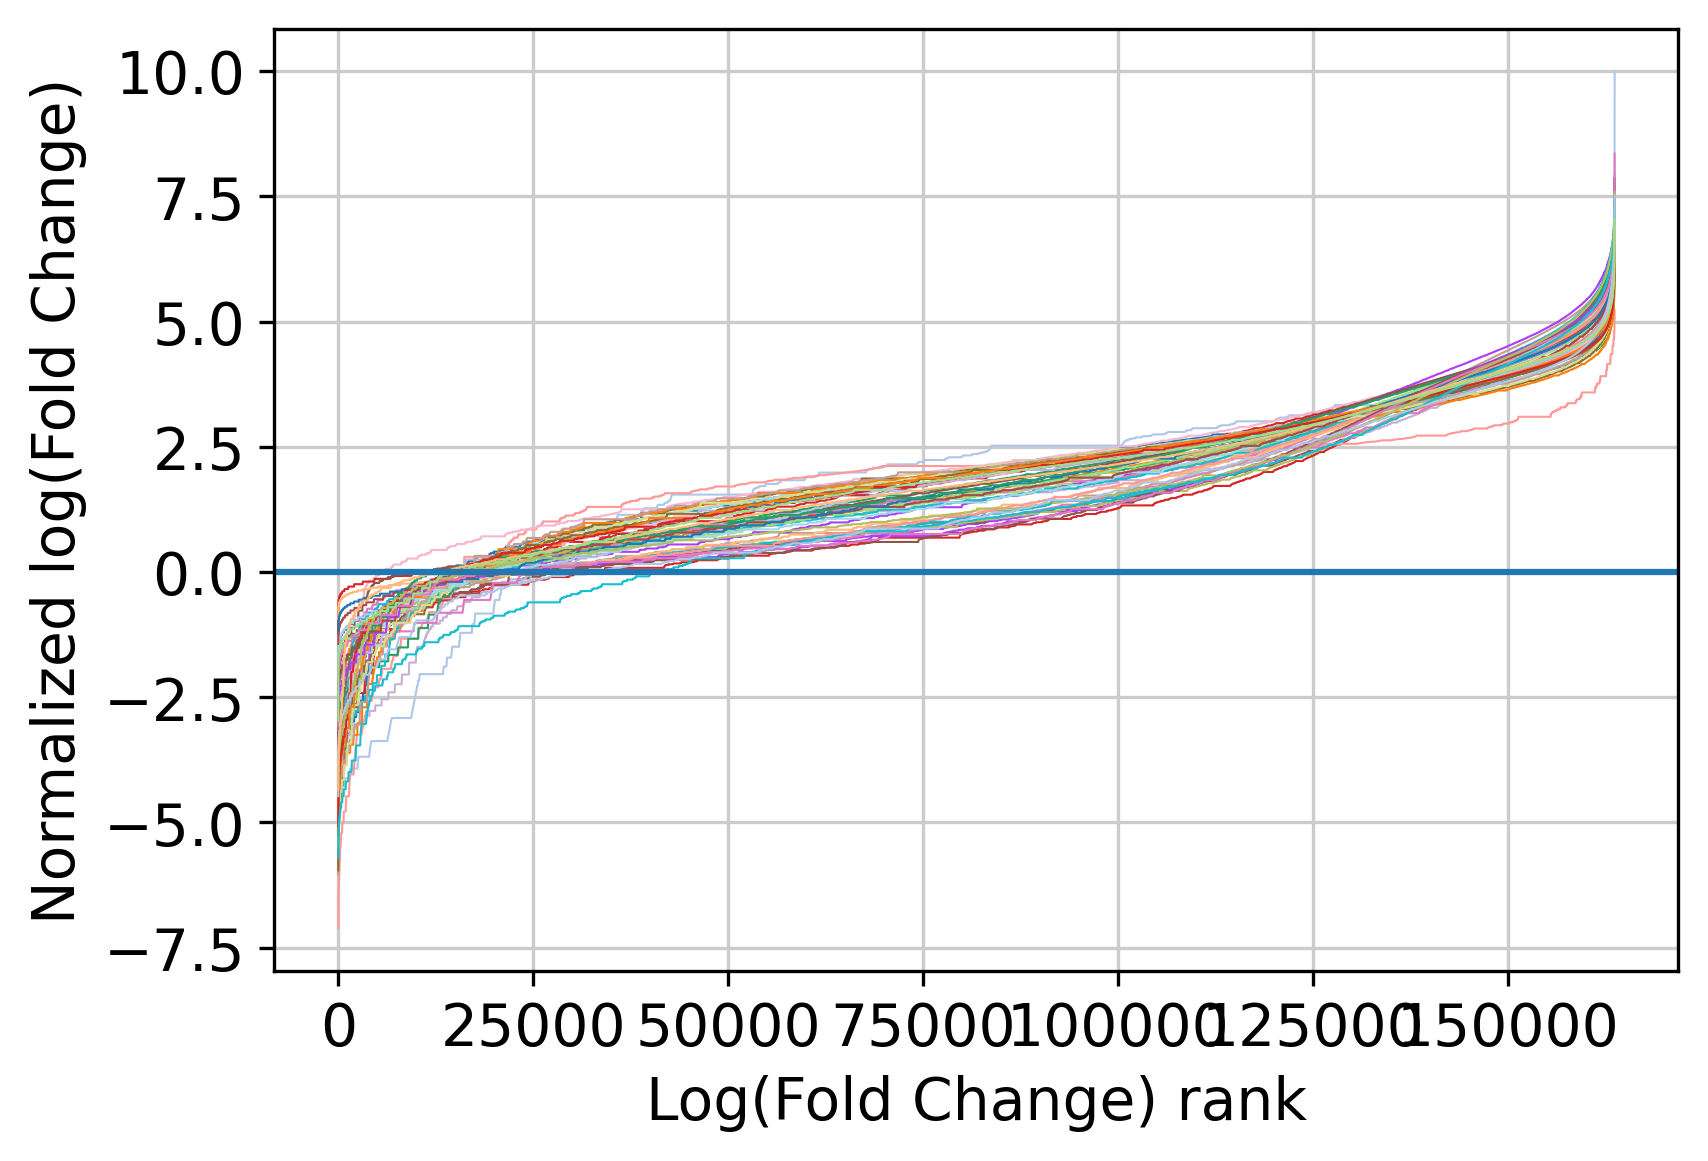

In [9]:
muffin.tools.rescale_input_center_scale(dataset, plot=True)
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]

The next step is to fit the mean-variance relationship and the compute residuals to the fitted Negative Binomial model.

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:475: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  dataset.var["means"] = stats.computeMeanNormFactors(dataset.X,
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/baseEnv/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 248 tasks      | elapsed:   45.3s
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:   46.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:   29.5s
[Parallel(n_jobs=16)]: Done 86048 tasks      | elapsed:  1.4

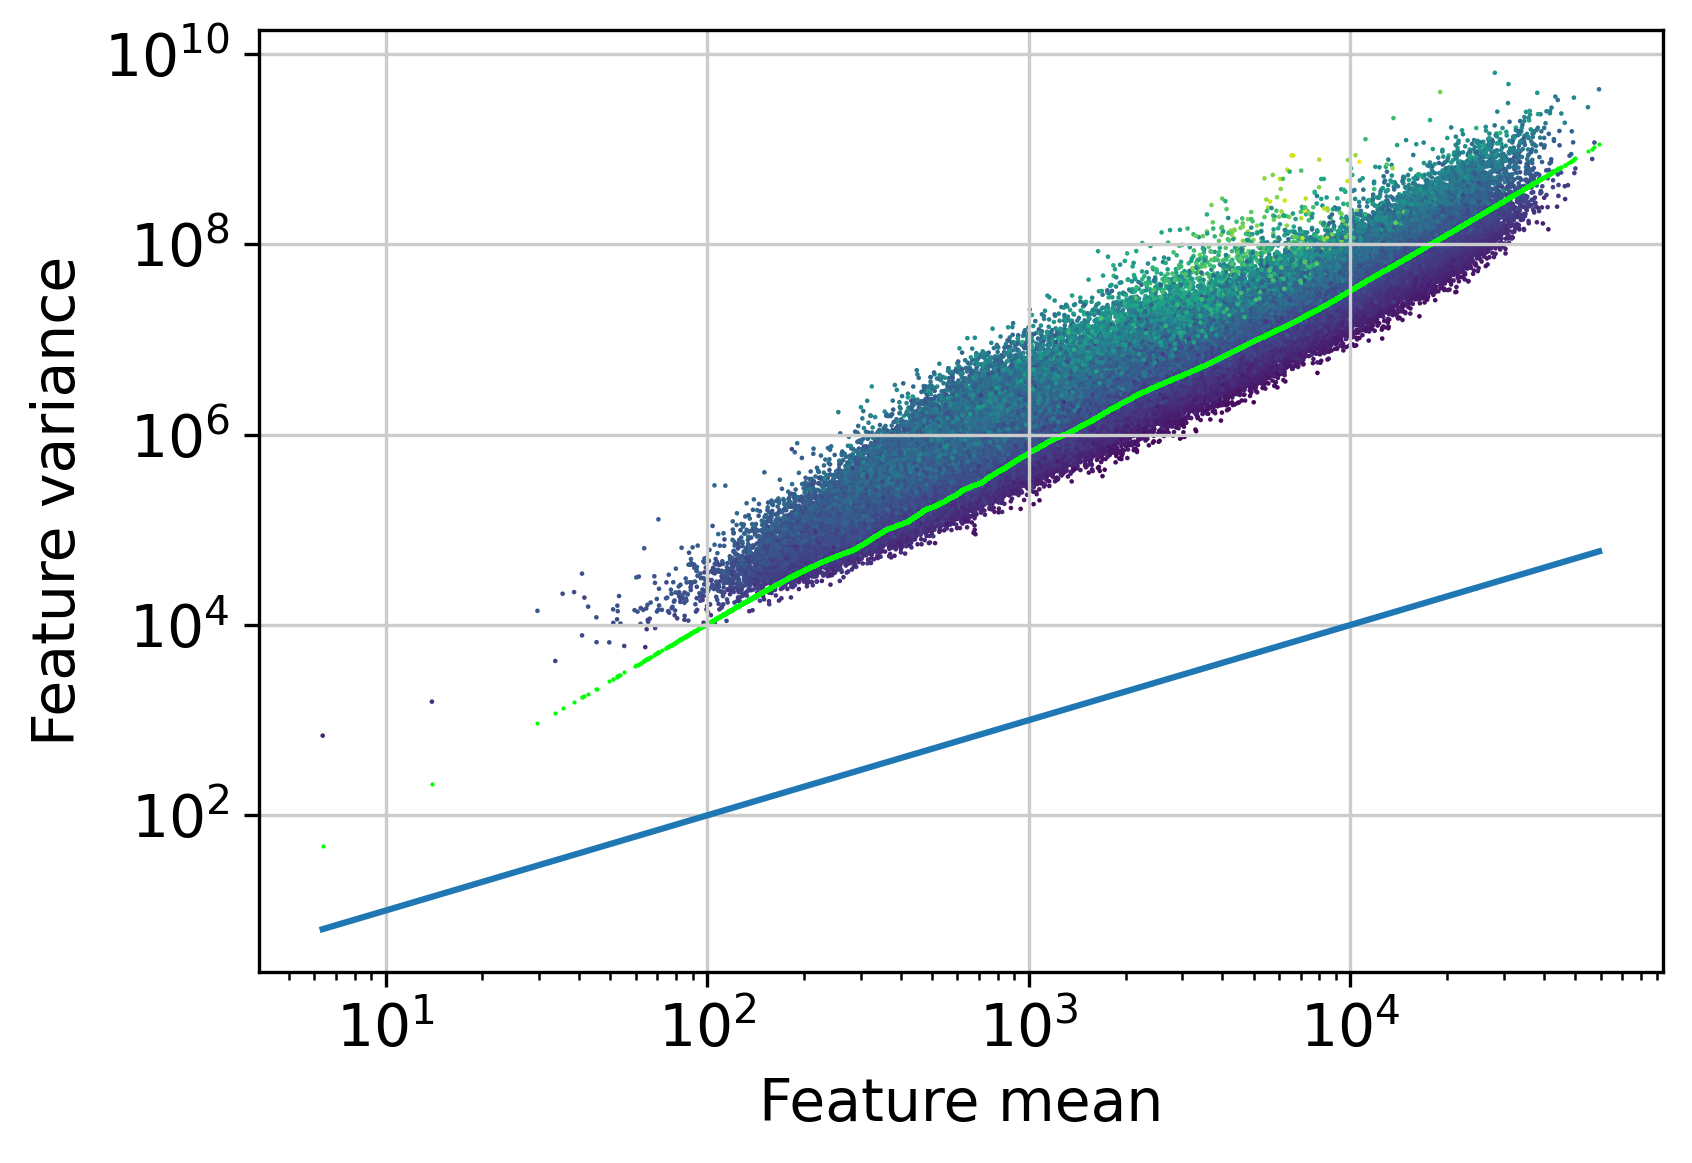

AnnData object with n_obs × n_vars = 52 × 163624
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    obsm: 'design'
    layers: 'input', 'normalization_factors', 'residuals'

In [10]:
muffin.tools.compute_residuals(dataset, maxThreads=16)

We can perform feature selection to remove peaks with low information. Additionally for ChIP-seq we propose a tool to remove features with insufficient enrichment over input, which can be useful if you use a large catalogue of regions without peak calling. As peak calling was already performed, almost all features are passing this step.

<Figure size 1800x1200 with 0 Axes>

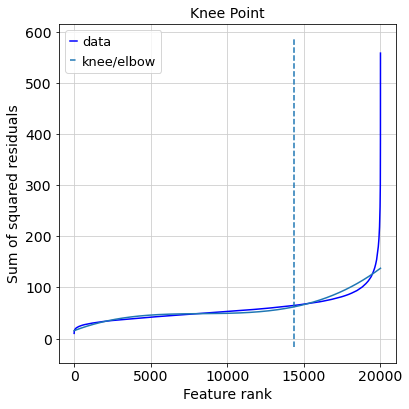

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


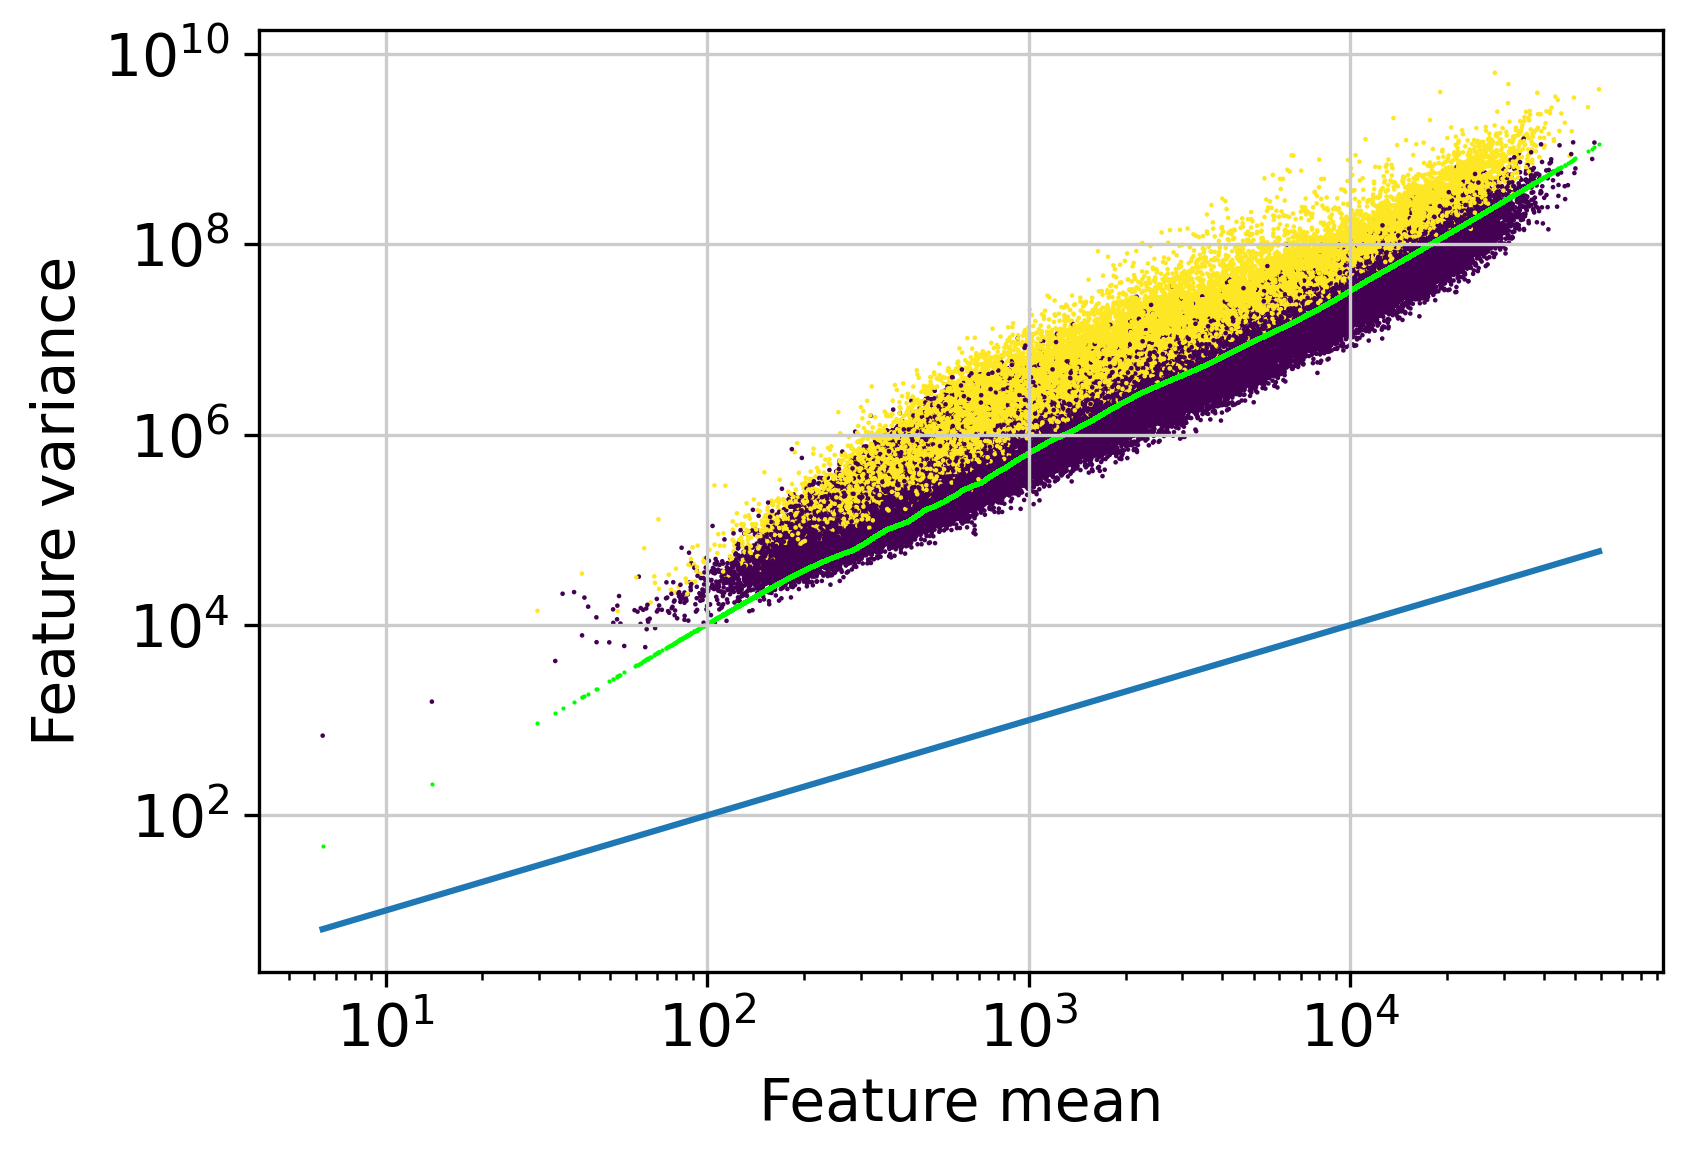

0.9992360533907007


In [11]:
peaks = muffin.tools.pseudo_peak_calling(dataset)
hv = muffin.tools.feature_selection_elbow(dataset)
print(np.mean(peaks))

Next, we perform dimensionnality reduction through with PCA and UMAP.

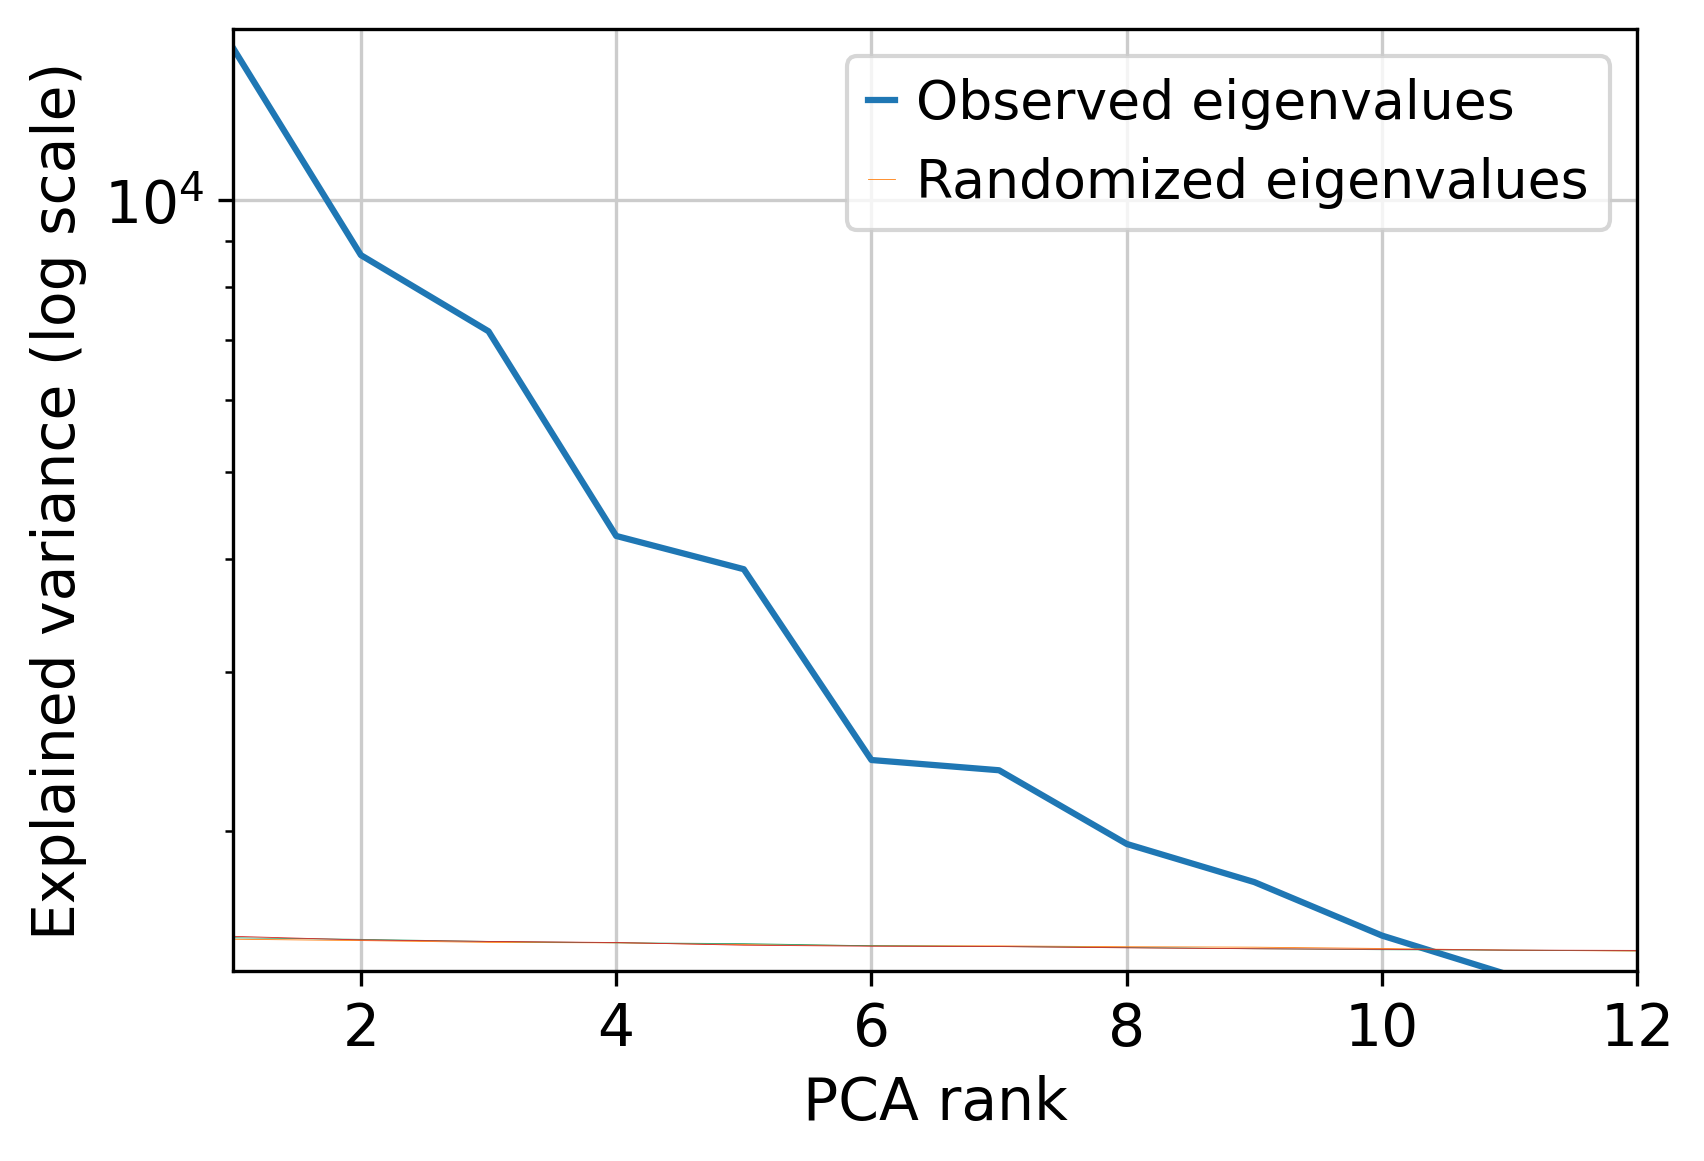

AnnData object with n_obs × n_vars = 52 × 163624
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random', 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'input', 'normalization_factors', 'residuals'

In [12]:
muffin.tools.compute_pa_pca(dataset, feature_mask=peaks&hv, plot=True)
muffin.tools.compute_umap(dataset)

Display the results. Note that we can use scanpy functions here!

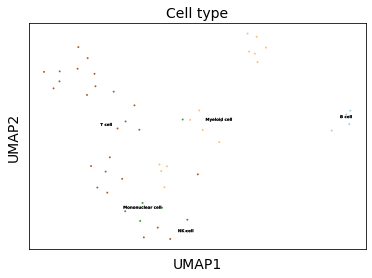

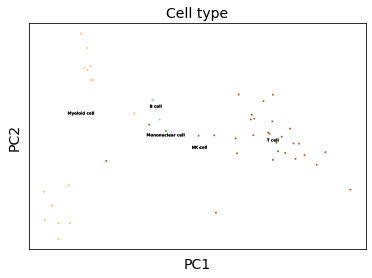

In [13]:
# Append cell type info to the dataset
dataset.obs["Cell type detailed"] = metadata_chip["Biosample term name"].values
dataset.obs["Cell type"] = metadata_chip["Biosample cell type"].values
sc.pl.umap(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')
sc.pl.pca(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')

We can also use heatmaps, even if we have a large number of features :

46293


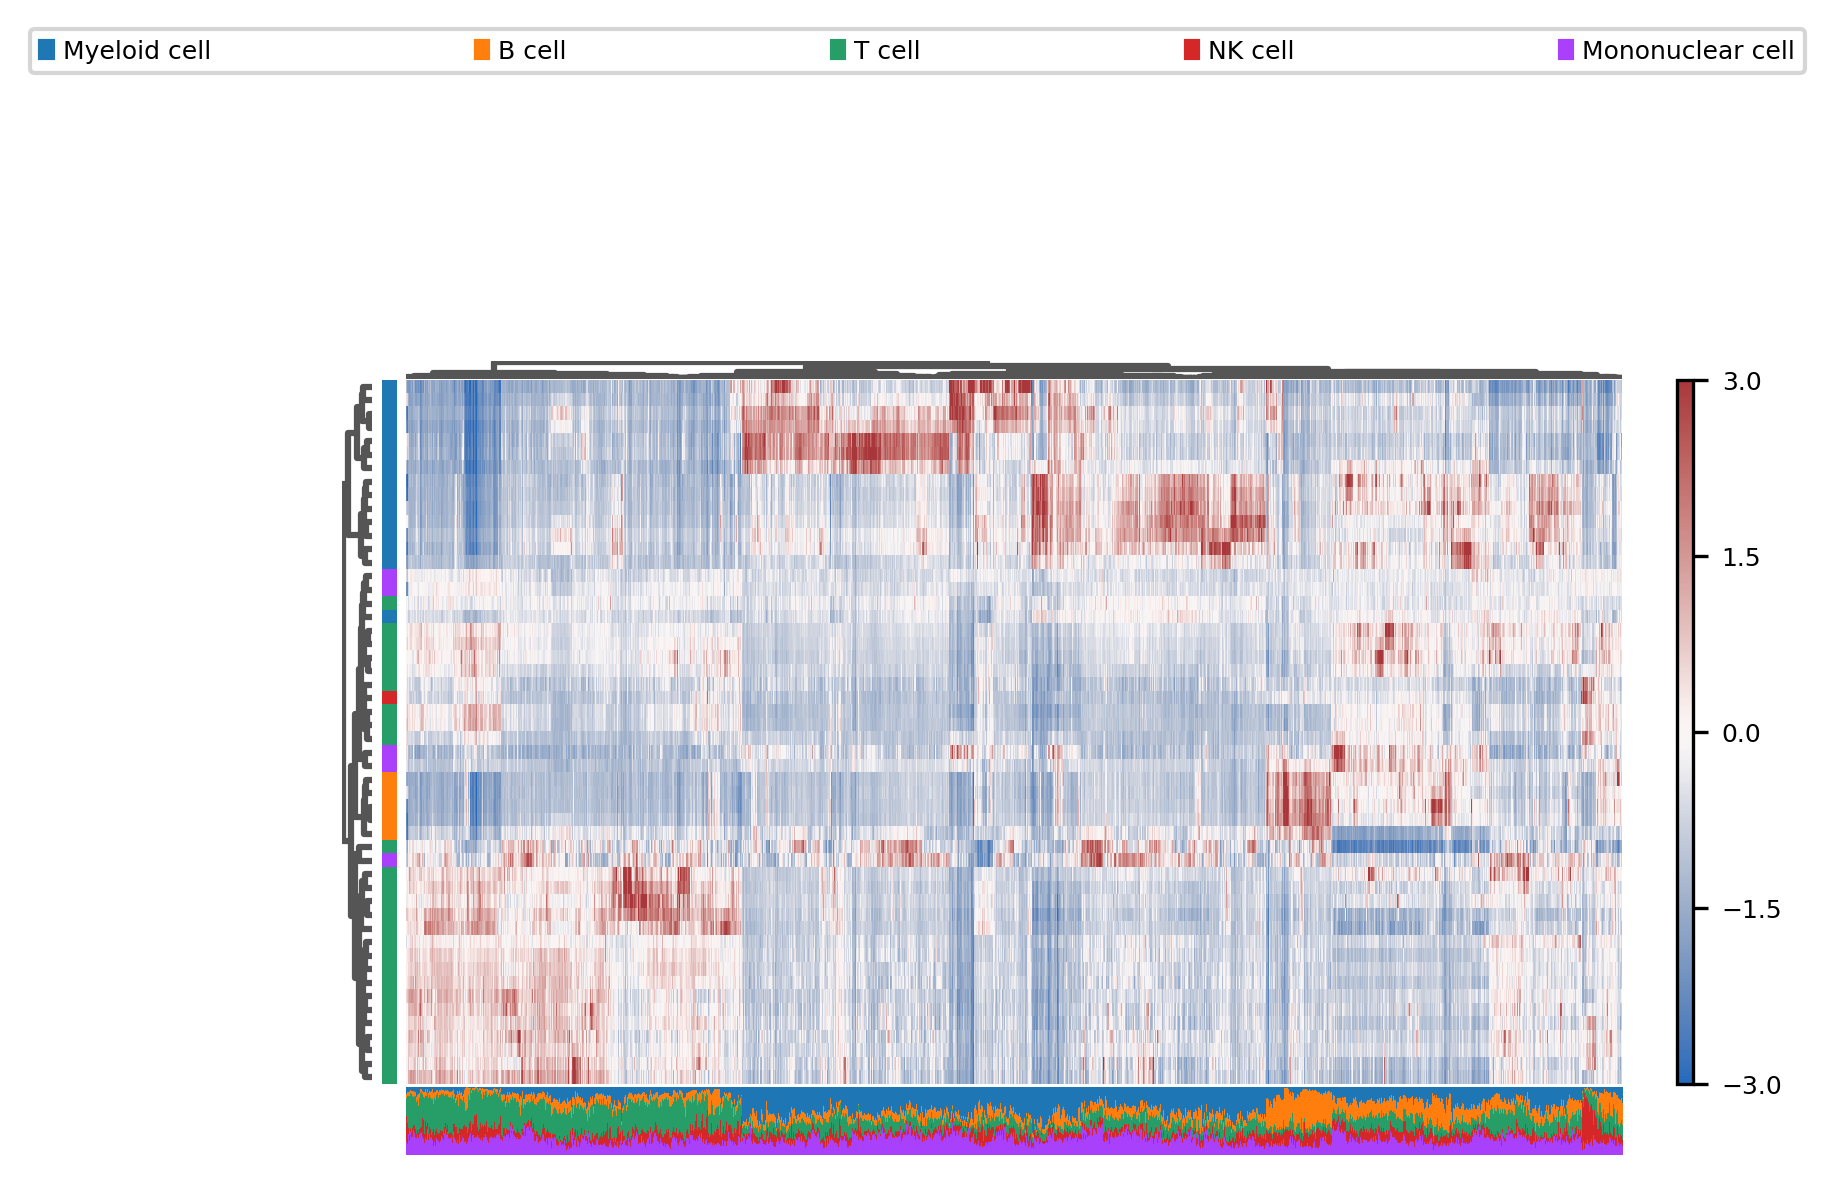

In [14]:
print((peaks & hv).sum())
fig, ax = muffin.plots.mega_heatmap(dataset[:, peaks & hv], layer="residuals", label_col="Cell type", vmin=-3, vmax=3)

Let's find the differentially bound regions between T-cells and B-cells:

In [15]:
# First subset our dataset
selected = dataset[(dataset.obs["Cell type"] == "B cell") | (dataset.obs["Cell type"] == "T cell")]
muffin.tools.differential_expression_A_vs_B(selected, category="Cell type", 
                                        ref_category="T cell")


Comparing B cell to (reference) T cell
Using DESeq2 with normalization factors per row, per gene


R[write to console]: converting counts to integer mode

R[write to console]: using pre-existing normalization factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 867 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

/shared/ifbstor1/projects/pol2_chipseq/newPkg/

Let's have a first look at the best markers between B and T cells :

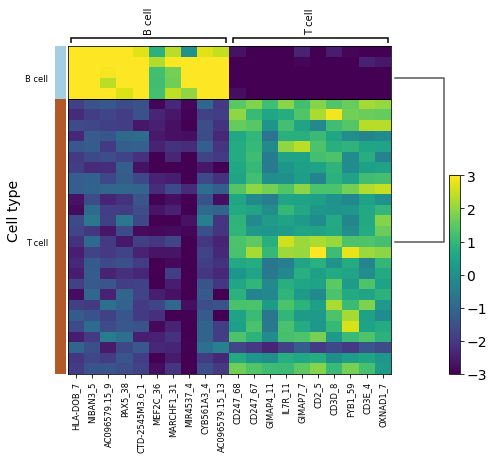

z-score  log2FoldChange        pvalue          padj
CD247_68      -13.920769       -4.481708  4.737805e-44  7.129355e-39
HLA-DOB_7      13.734425        5.132409  6.315563e-43  3.251994e-38
NIBAN3_5       13.732526        4.728592  6.483327e-43  3.251994e-38
AC096579.15_9  13.472273        5.572783  2.277462e-41  8.567698e-37
CD247_67      -13.326811       -5.006320  1.616624e-40  4.865326e-36
...                  ...             ...           ...           ...
CSTA_1         -0.224709       -0.085274  8.222058e-01  1.000000e+00
CASR_10        -1.651376       -0.782505  9.866185e-02  1.000000e+00
RN7SL371P_1    -1.365401       -0.624550  1.721269e-01  1.000000e+00
HSPBAP1_7      -1.062125       -0.469440  2.881791e-01  1.000000e+00
DDX11L1_1      -0.683787       -0.252772  4.941094e-01  1.000000e+00

[163624 rows x 4 columns]

In [16]:
sc.pl.rank_genes_groups_heatmap(selected,layer="residuals", 
                                use_raw=False, vmin=-3, vmax=3, 
                                cmap='viridis')
selected.varm["DE_results"].sort_values("padj")


We can already see genes specific to T cells (CD3E, CD3D...) and some specific to B cells (BLNK, BLK...). We can go further and perform a Genomic Regions Enrichment Analysis to get a GSEA of nearby genes.

In [17]:
# Retrieve DE regions
DE_indexes = (selected.varm["DE_results"]["padj"] < 0.05) & (np.abs(selected.varm["DE_results"]["log2FoldChange"]) > 1.0)
all_regions = selected.var[["Chromosome", "Start", "End"]]
query = all_regions[DE_indexes]
# Perform GREA
gsea_results = gsea_obj.find_enriched(query, all_regions, cores=16)
gsea_results

P(Beta > 0)      Beta  BH corrected p-value  -log10(qval)  \
0                                                                        
GO:0002250  1.207669e-50  0.556086          1.130982e-46  4.594654e+01   
GO:0046649  1.852993e-17  0.270919          8.676639e-14  1.306165e+01   
GO:0042110  5.956862e-15  0.293979          1.730784e-11  1.076176e+01   
GO:0045321  7.392565e-15  0.229215          1.730784e-11  1.076176e+01   
GO:0050851  1.485745e-14  0.462123          2.782800e-11  1.055552e+01   
...                  ...       ...                   ...           ...   
GO:0006281  9.999945e-01 -0.202640          1.000000e+00  1.585344e-08   
GO:0070925  9.999969e-01 -0.165714          1.000000e+00  1.585344e-08   
GO:0007098  9.999987e-01 -0.515737          1.000000e+00  1.585344e-08   
GO:0000226  9.999993e-01 -0.222038          1.000000e+00  1.585344e-08   
GO:0007017  1.000000e+00 -0.205916          1.000000e+00  1.585344e-08   

            -log10(pval)        FC  \
0                                    
GO:0002250  4.991805e+01  1.743834   
GO:0046649  1.673213e+01  1.311169   
GO:0042110  1.422498e+01  1.341755   
GO:0045321  1.413120e+01  1.257612   
GO:0050851  1.382806e+01  1.587440   
...                  ...       ...   
GO:0006281  2.406854e-06  0.816572   
GO:0070925  1.343258e-06  0.847289   
GO:0007098  5.744910e-07  0.597061   
GO:0000226  3.235225e-07  0.800885   
GO:0007017  1.585344e-08  0.813902   

                                                   Name  Total hits  
0                                                                    
GO:0002250                     adaptive immune response        2977  
GO:0046649                        lymphocyte activation        4109  
GO:0042110                            T cell activation        3163  
GO:0045321                         leukocyte activation        4547  
GO:0050851  antigen receptor-mediated signaling pathway        1363  
...                                                 ...         ...  
GO:0006281                                   DNA repair         909  
GO:0070925                           organelle assembly        1582  
GO:0007098                             centrosome cycle         133  
GO:0000226        microtubule cytoskeleton organization         918  
GO:0007017                    microtubule-based process        1363  

[9365 rows x 8 columns]

We do observe an enrichment of immune and T/B Cells related terms.

In [19]:
import plotly.offline as pyo
pyo.init_notebook_mode()
gsea_obj.cluster_treemap(gsea_results)

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/grea.py:426: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/grea.py:427: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/grea.py:429: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

We can save our work to avoid recomputing everything. It can easily be re-loaded using :  anndata.read_h5ad(path)

In [20]:
dataset.write("h3k4me3_results/dataset.h5ad")